Clipped raster saved successfully.


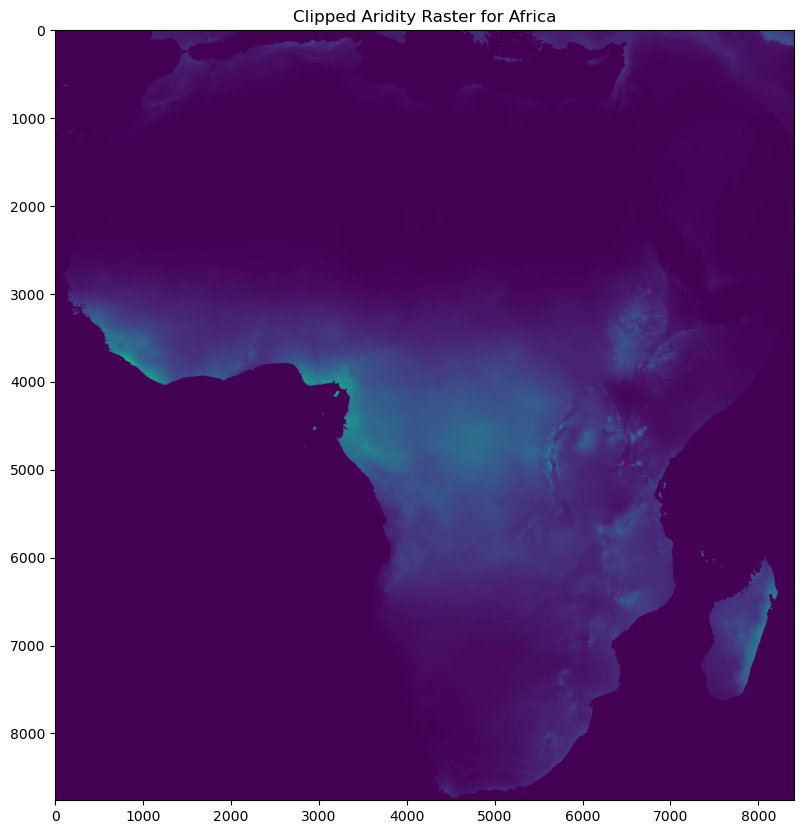

In [1]:
import numpy as np
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import box
import os
import yaml
import matplotlib.pyplot as plt

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

aridity_threshold = 0.5 * 10000

with rasterio.open(resolve_path(config['Global_Aridity_Raster_path'])) as src:
    # Define the bounding box for Africa (in degrees)
    minx, miny = -18.0, -35.0  # approximate coordinates for Africa
    maxx, maxy = 52.0, 38.0

    # Create a bounding box polygon
    bbox = box(minx, miny, maxx, maxy)
    bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox]}, index=[0], crs=src.crs)

    # Clip the raster to the bounding box
    out_image, out_transform = mask(src, bbox_gdf.geometry, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    # Save the clipped raster
    clipped_tif_path = resolve_path(config['Africa_Arid_Regions_tif_path'])
    with rasterio.open(clipped_tif_path, "w", **out_meta) as dest:
        dest.write(out_image)

    print("Clipped raster saved successfully.")

# Now let's just load and visualize the clipped raster to ensure it's correct

with rasterio.open(clipped_tif_path) as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(src.read(1), cmap='viridis')
    ax.set_title("Clipped Aridity Raster for Africa")
    plt.show()


In [2]:
from osgeo import gdal
import numpy as np
import geopandas as gpd
from shapely.geometry import shape
import rasterio
from rasterio.features import shapes
from tqdm import tqdm
import yaml
import os

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

# Enable GDAL exceptions
gdal.UseExceptions()

# Read the trimmed Africa aridity index tif file
aridity_tif = resolve_path(config['Africa_Arid_Regions_tif_path'])  # Replace with the path to your file
ds = gdal.Open(aridity_tif)
if ds is None:
    raise ValueError("Could not open the dataset. Please check the file path.")

# Resample the dataset to a lower resolution to make processing faster
resample_scale = 0.1  # Resample scale factor (e.g., 0.1 for 10% of the original size)
width = int(ds.RasterXSize * resample_scale)
height = int(ds.RasterYSize * resample_scale)
resampled_aridity_data = ds.ReadAsArray(buf_xsize=width, buf_ysize=height)

# Filter the aridity data for values < 5000 (0.5 * 10000) using vectorized operations
filtered_aridity_data = np.where((resampled_aridity_data < 5000) & (resampled_aridity_data > 0), resampled_aridity_data, np.nan).astype(np.float32)

# Use rasterio and shapes directly on the filtered array
with rasterio.open(aridity_tif) as src:
    transform = src.transform
    # Adjust the transform to account for the resampling
    resampled_transform = src.transform * src.transform.scale(
        (src.width / width),
        (src.height / height)
    )
    shapes_generator = shapes(filtered_aridity_data, mask=~np.isnan(filtered_aridity_data), transform=resampled_transform)

# Create a GeoDataFrame
geoms = []
valid_shape_count = 0
for shp, val in tqdm(shapes_generator, desc="Generating shapes"):
    if val < 5000:
        geoms.append(shape(shp))
        valid_shape_count += 1
        if valid_shape_count % 10000 == 0:
            print(f"Processed {valid_shape_count} shapes")

gdf = gpd.GeoDataFrame(geometry=geoms)

# Save the GeoDataFrame as a shapefile
output_path = resolve_path(config['Africa_Arid_Regions_Filtered_path'])
print(f"Saving shapefile to {output_path}")
gdf.to_file(output_path)
print("Shapefile saved successfully")




Generating shapes: 18412it [00:00, 33121.40it/s]

Processed 10000 shapes


Generating shapes: 26580it [00:01, 34273.75it/s]

Processed 20000 shapes


Generating shapes: 34180it [00:01, 35054.55it/s]

Processed 30000 shapes


Generating shapes: 45209it [00:01, 35325.54it/s]

Processed 40000 shapes


Generating shapes: 55851it [00:01, 33625.32it/s]

Processed 50000 shapes


Generating shapes: 66115it [00:02, 33927.38it/s]

Processed 60000 shapes


Generating shapes: 76358it [00:02, 33846.78it/s]

Processed 70000 shapes


Generating shapes: 86505it [00:02, 29361.28it/s]

Processed 80000 shapes


Generating shapes: 96777it [00:03, 32541.01it/s]

Processed 90000 shapes


Generating shapes: 107892it [00:03, 36041.85it/s]

Processed 100000 shapes


Generating shapes: 116910it [00:03, 40635.55it/s]

Processed 110000 shapes


Generating shapes: 125928it [00:03, 42992.03it/s]

Processed 120000 shapes


Generating shapes: 134655it [00:04, 43328.46it/s]

Processed 130000 shapes


Generating shapes: 146736it [00:04, 37106.97it/s]

Processed 140000 shapes


Generating shapes: 154190it [00:04, 35969.20it/s]

Processed 150000 shapes


Generating shapes: 165204it [00:04, 36219.28it/s]

Processed 160000 shapes


Generating shapes: 172405it [00:05, 30069.46it/s]

Processed 170000 shapes


Generating shapes: 186661it [00:05, 34450.23it/s]

Processed 180000 shapes


Generating shapes: 193654it [00:05, 34558.68it/s]

Processed 190000 shapes


Generating shapes: 204026it [00:06, 32880.61it/s]

Processed 200000 shapes


Generating shapes: 214758it [00:06, 34696.65it/s]

Processed 210000 shapes


Generating shapes: 225600it [00:06, 35651.26it/s]

Processed 220000 shapes


Generating shapes: 236303it [00:07, 35399.51it/s]

Processed 230000 shapes


Generating shapes: 247198it [00:07, 35766.90it/s]

Processed 240000 shapes


Generating shapes: 247713it [00:07, 32352.42it/s]


Saving shapefile to /home/ermiller/Africa_Irrigation/Data/Processed/Africa_Arid_Regions.shp
Shapefile saved successfully


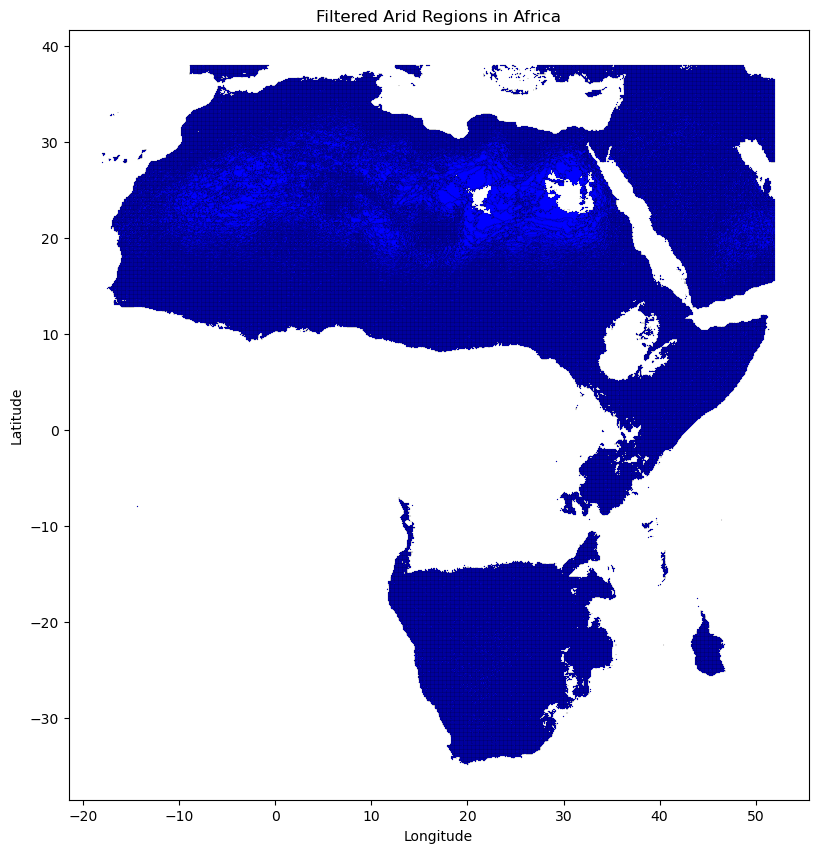

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import yaml
import os

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

# Path to the saved shapefile
shapefile_path = resolve_path(config['Africa_Arid_Regions_Filtered_path'])

# Read the shapefile using geopandas
gdf = gpd.read_file(shapefile_path)

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='blue', edgecolor='k', linewidth=0.1)
ax.set_title("Filtered Arid Regions in Africa")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()
